In [11]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

from pathlib import Path
from warnings import simplefilter

from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

## Читаем `csv` файлы из отдельной директории

In [3]:
#Папка где у меня файлы
path = "f:\\Datasets\\kaggle-store-sales"

# ШАГ 1. Запоминаем текущую папку и меняем ее на нужную = где файл лежит
# Check current working directory.
main_path = os.getcwd()
print("Current working directory", main_path)

# Now change the directory
os.chdir( path )

# Check current working directory.
cur_path = os.getcwd()
print("Directory changed successfully",cur_path)

# ШАГ 2. Читаем файл в датафрейм df (оперативную память) для трансформации
# прочитаем файл
files = ['holidays_events', 'oil', 'sample_submission','stores', 'test', 'train', 'transactions']

dd = {}
for file in files:
    if file == 'train':
        dtype = {
            'store_nbr': 'category',
            'family': 'category',
            'sales': 'float32',
            'onpromotion': 'uint64',
        }
        store_sales = pd.read_csv(
            file + '.csv',
            dtype=dtype,
            parse_dates=['date'],  
        )
        store_sales = store_sales.set_index('date').to_period('D')
        store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
        dd[file] = store_sales
        average_sales = store_sales.groupby('date').mean()['sales']
    else:
        dd[file] = pd.read_csv(file + '.csv')
    

# ШАГ 3. Возвращаем основную рабочую директорию 
os.chdir(main_path)
cur_path = os.getcwd()
print("Directory changed successfully", cur_path)

Current working directory g:\github_projects\study-time-series-analysis\kaggle-ts
Directory changed successfully f:\Datasets\kaggle-store-sales
Directory changed successfully g:\github_projects\study-time-series-analysis\kaggle-ts


In [2]:
data_dir = Path("../data/kaggle-ts-course")
retail_sales = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    parse_dates=['Month'],
    index_col='Month',
).to_period('D')
food_sales = retail_sales.loc[:, 'FoodAndBeverage']
auto_sales = retail_sales.loc[:, 'Automobiles']

In [4]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# 1) Determine trend with a moving average plot
The US Retail Sales dataset contains monthly sales data for a number of retail industries in the United States. Run the next cell to see a plot of the Food and Beverage series.

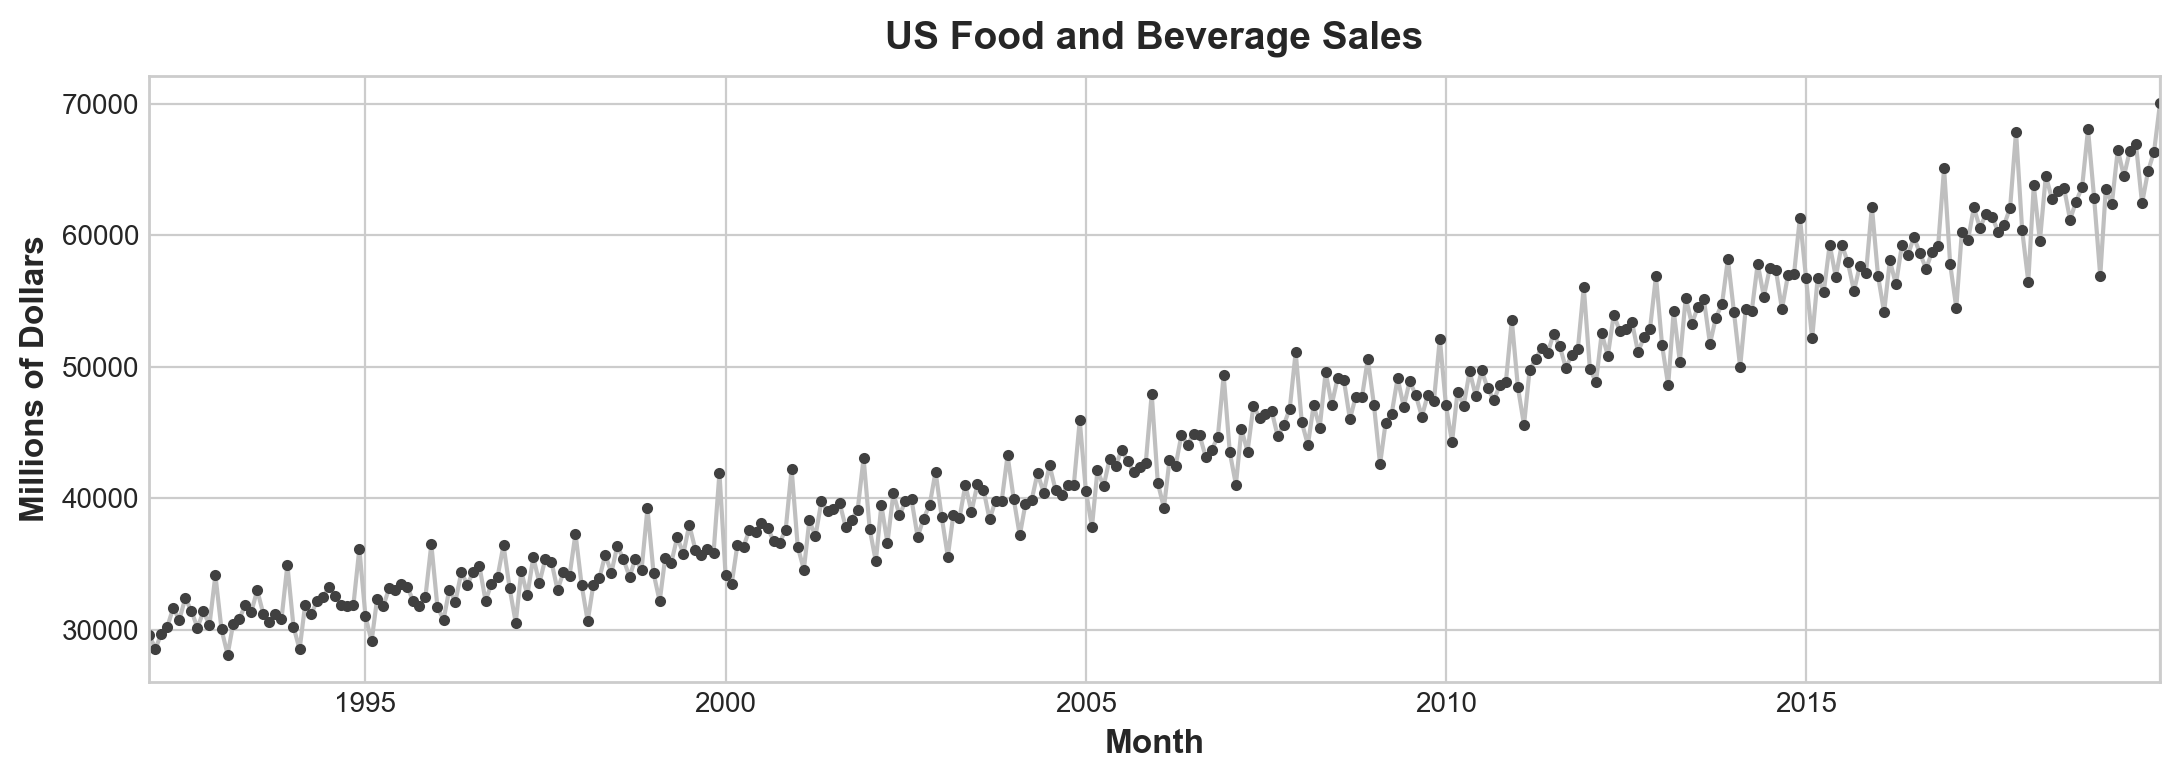

In [5]:
ax = food_sales.plot(**plot_params)
ax.set(title="US Food and Beverage Sales", ylabel="Millions of Dollars");

Now make a moving average plot to estimate the trend for this series.

In [6]:
food_sales.head(15)

Month
1992-01-01    29589
1992-02-01    28570
1992-03-01    29682
1992-04-01    30228
1992-05-01    31677
1992-06-01    30769
1992-07-01    32402
1992-08-01    31469
1992-09-01    30162
1992-10-01    31407
1992-11-01    30388
1992-12-01    34170
1993-01-01    30039
1993-02-01    28126
1993-03-01    30455
Freq: D, Name: FoodAndBeverage, dtype: int64

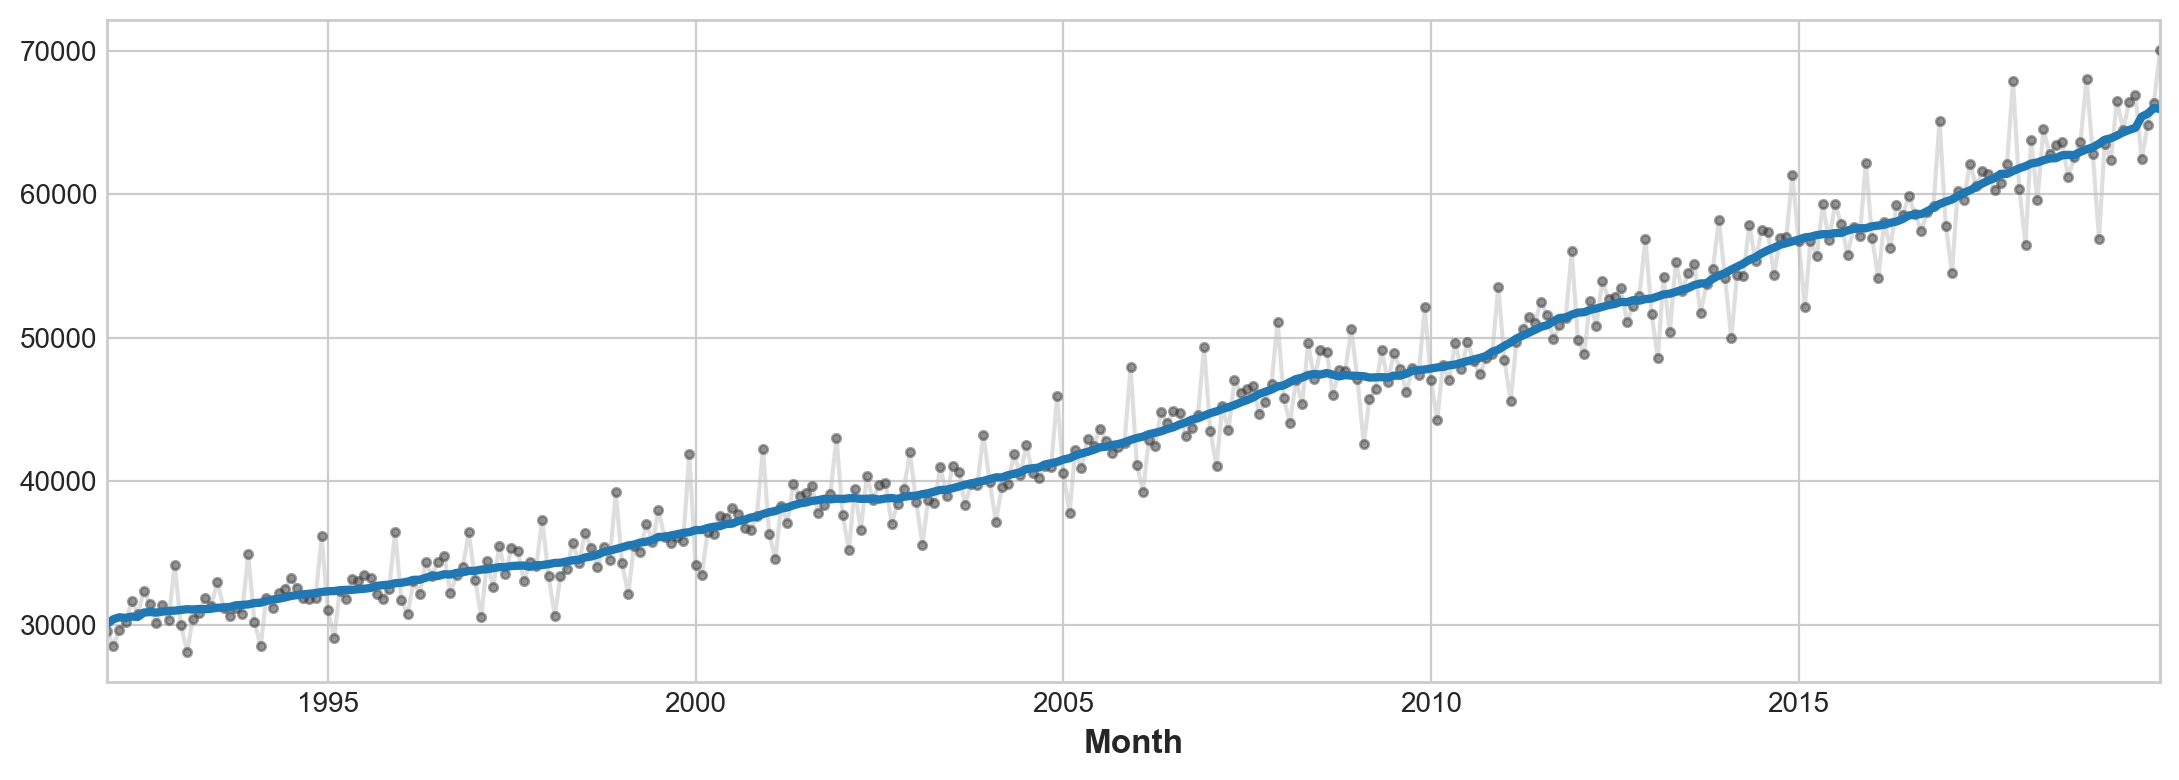

In [7]:
trend = food_sales.rolling(
    window=12,
    center=True,
    min_periods=6,
).mean()

# Make a plot
ax = food_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

# 2) Identify trend
What order polynomial trend might be appropriate for the Food and Beverage Sales series? Can you think of a non-polynomial curve that might work even better?

answer: 

The upwards bend in the trend suggests an order 2 (quadratic) polynomial might be appropriate.

If you've worked with economic time series before, you might guess that the growth rate in Food and Beverage Sales is best expressed as a percent change. Percent change can often be modeled using an exponential curve.


We'll continue using the time series of average sales in this lesson. Run this cell to see a moving average plot of average_sales estimating the trend.

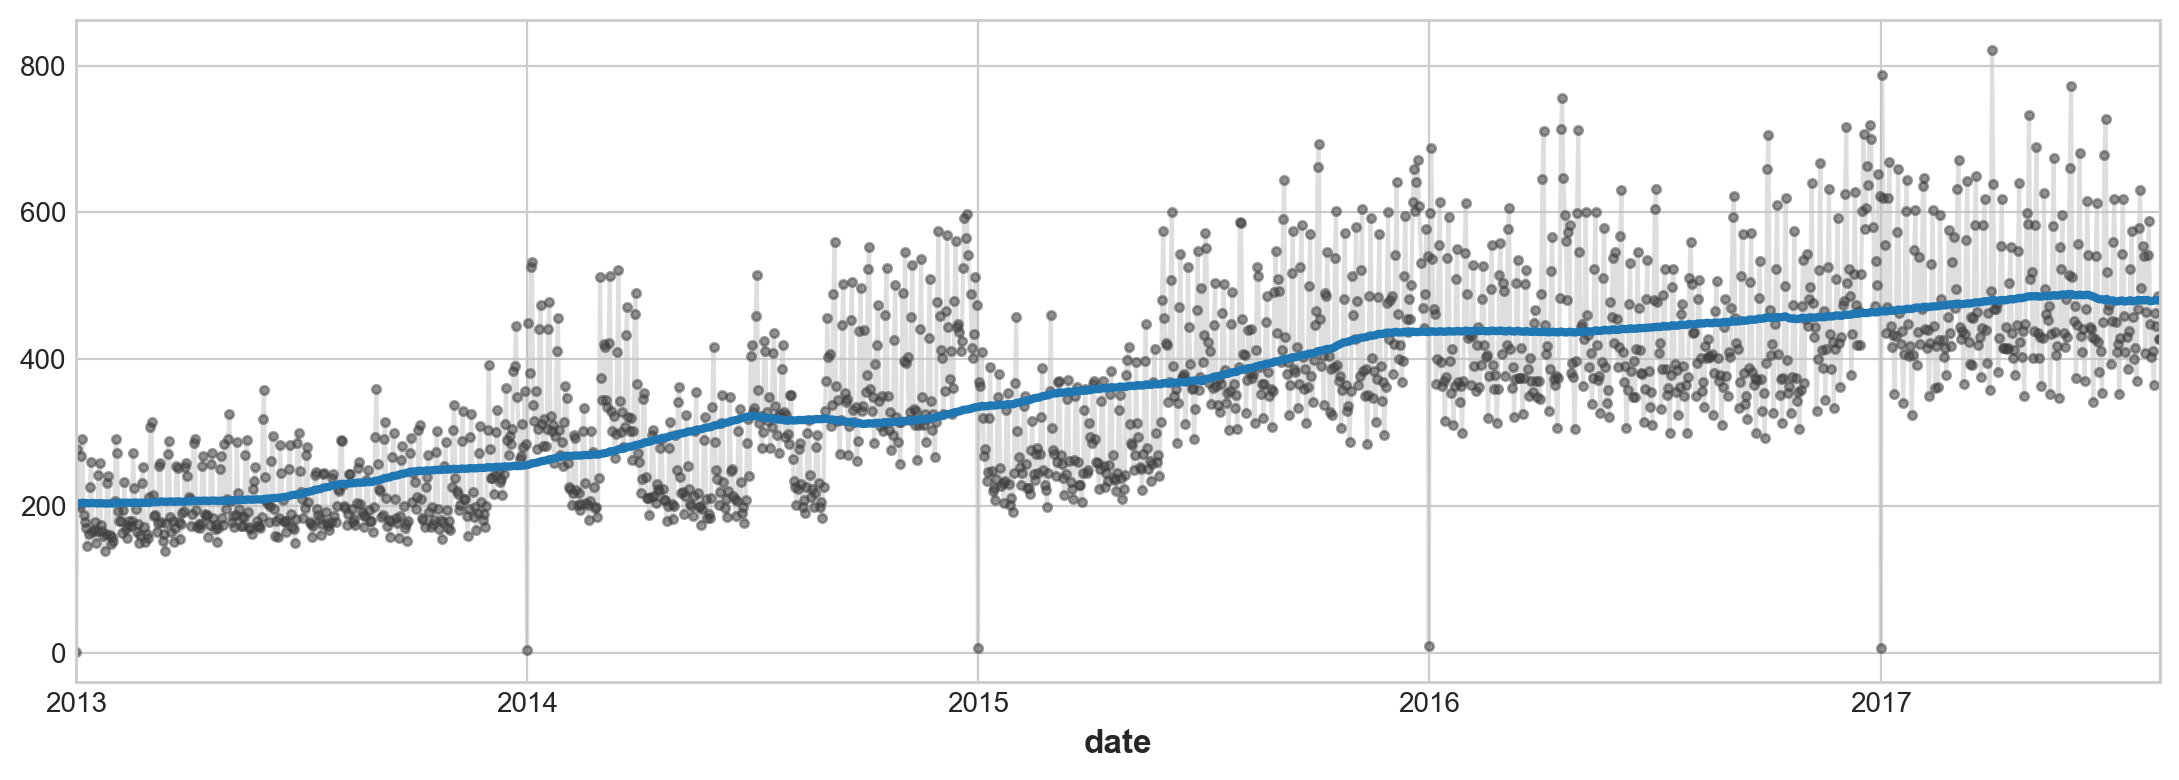

In [8]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

# 3) Create a Trend Feature

Use DeterministicProcess to create a feature set for a cubic trend model. Also create features for a 90-day forecast

In [12]:
y = average_sales.copy()

# YOUR CODE HERE: Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index=y.index,  # dates from the training data    
    order=3,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()

# YOUR CODE HERE: Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=90)


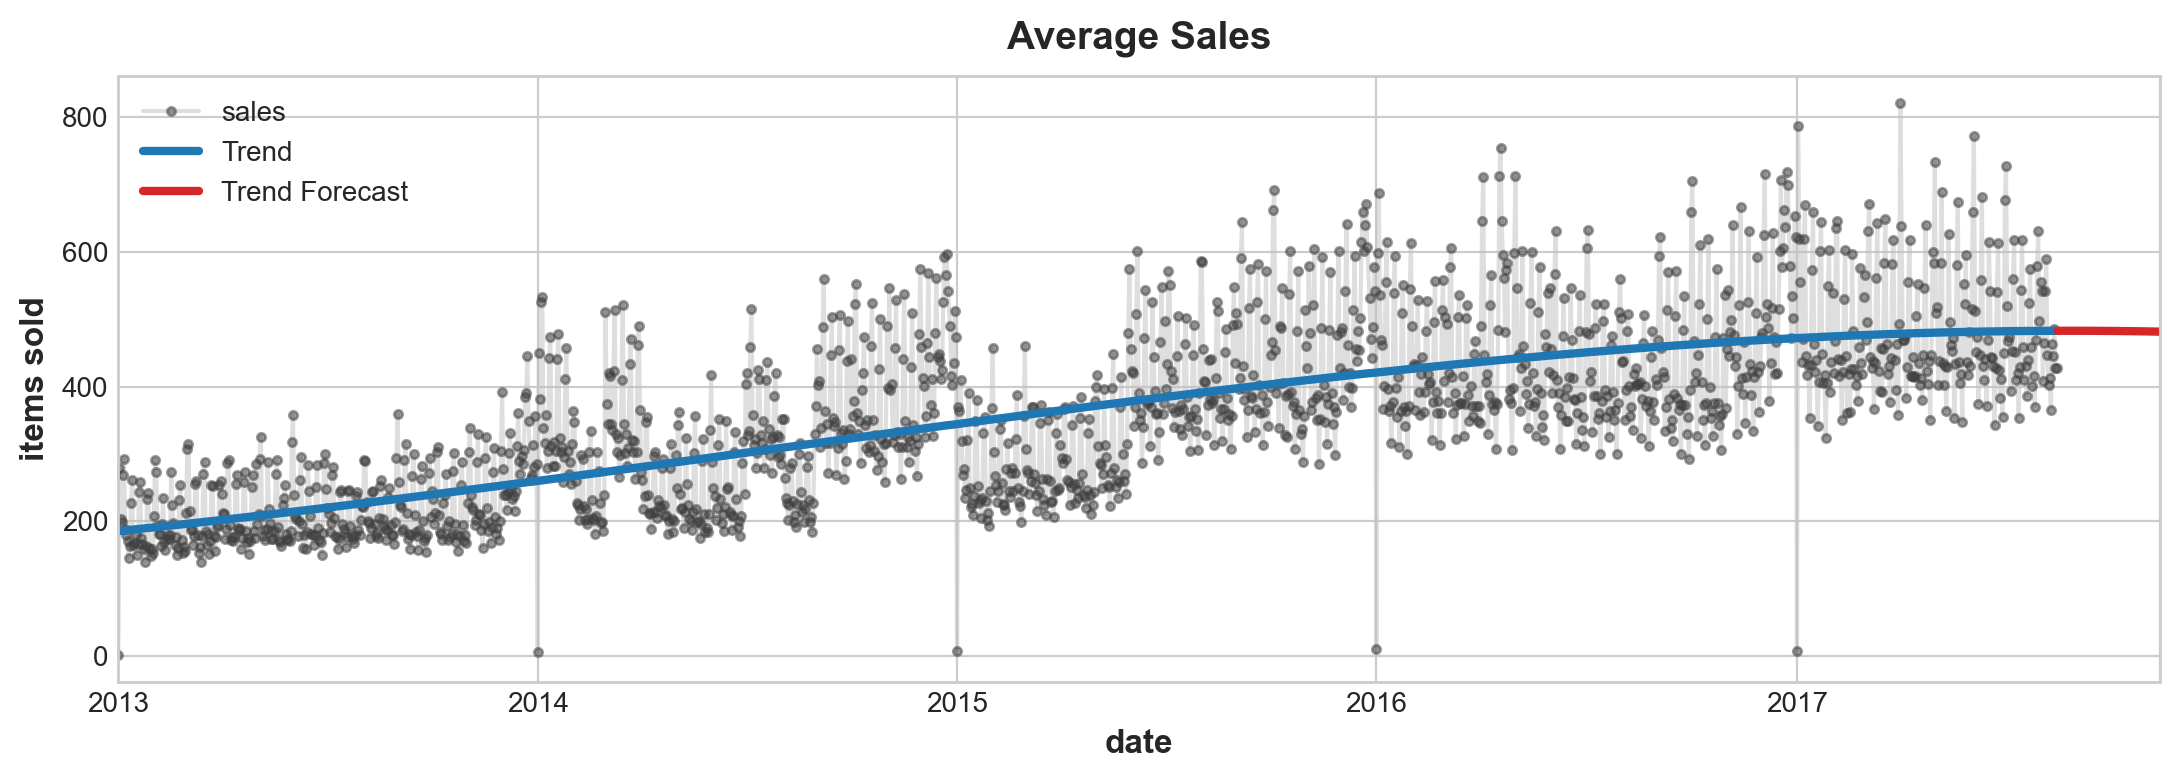

In [13]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

One way to fit more complicated trends is to increase the order of the polynomial you use. To get a better fit to the somewhat complicated trend in Store Sales, we could try using an order 11 polynomial.

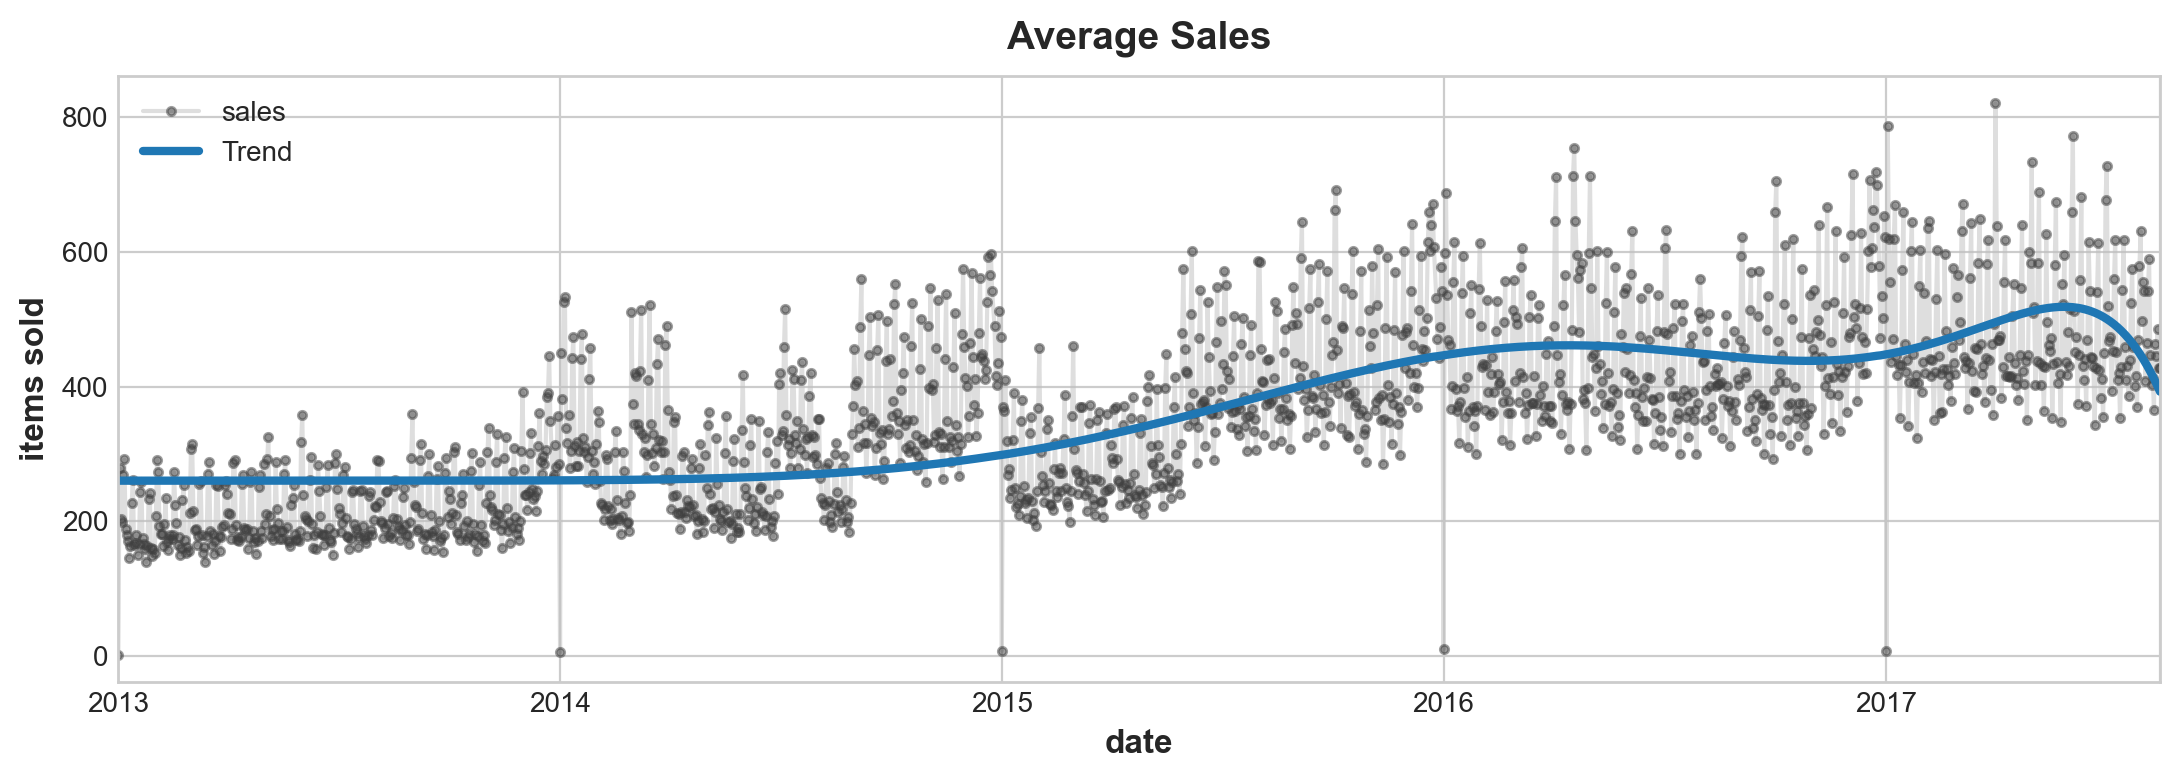

In [14]:
dp = DeterministicProcess(index=y.index, order=11)
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend();

# 4) Understand risks of forecasting with high-order polynomials

High-order polynomials are generally not well-suited to forecasting, however. Can you guess why?

answer:

An order 11 polynomial will include terms like `t ** 11`. Terms like these tend to diverge rapidly outside of the training period making forecasts very unreliable.

to see the same 90-day forecast using an order 11 polynomial. Does it confirm your intuition?

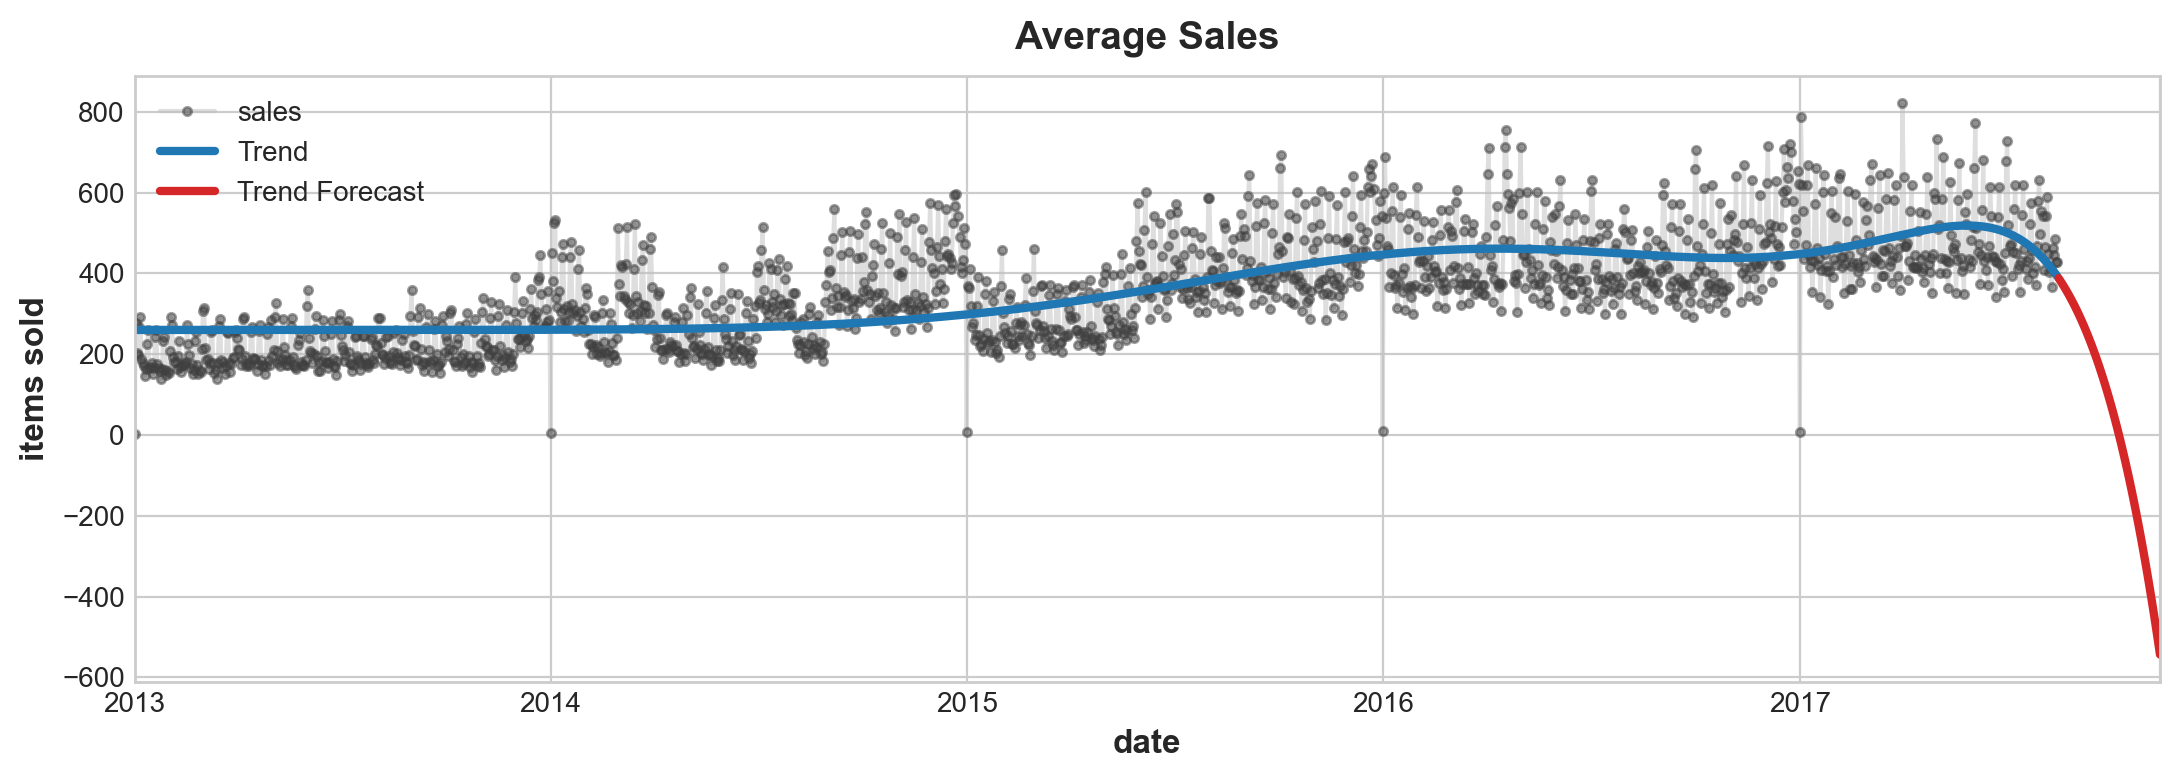

In [15]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();